# Analysis and Results Visualization

This script describes the procedure to request an analysis to the Viking Analytics Vibration service and how to query for the results of such analysis.
In addition, it shows some examples of how to visualize the results available after for the mode identification feature.

## Preliminaries

This procedure describes all the steps to request an analysis, get analysis results and plot those results using the functions in mvg_viz.
Local visualizations functions to create the figures are imported from mvg_viz. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from requests import HTTPError

# import mvg library with python bindings to mvg-API
from mvg import MVG, plotting

Note that the `TOKEN` is used both for authorization and authentication. Thus, each unique token represents a unique user and each user has their own unique database on the VA vibration service.

**You need to insert your token received from Viking Analytics here:**git

In [2]:
# Replace by your own Token
VALID_TOKEN = "Add token here"

Instantiate a session object with mvg library a session object basically caches the endpoint and the token, to simplify the the calls to the mvg library.

In [3]:
ENDPOINT = "https://api.beta.multiviz.com"
session = MVG(ENDPOINT, VALID_TOKEN)

## Analysis

In this example, we will use the sources uploaded by the "Sources and Measurement" example.
We start by seeing if the sources are available in the database.
Two sources "u0001" and "u0005" should appear as available.

NOTE: Include an hyperlink in the documentation to the ["Sources and Measurement"](sources_and_measurements.ipynb) example.

In [4]:
sources = session.list_sources()

print("Retrieved sources")
for src in sources:
    print(src)
    s_info = session.get_source(src['source_id'])
    print(f"Source info retrieved for one source: {s_info}")

Retrieved sources
{'source_id': 'u0001', 'meta': {'assetId': 'assetA', 'measPoint': 'mloc01', 'location': 'paris', 'updated': 'YES! I have been updated'}}
Source info retrieved for one source: {'source_id': 'u0001', 'meta': {'assetId': 'assetA', 'measPoint': 'mloc01', 'location': 'paris', 'updated': 'YES! I have been updated'}}
{'source_id': 'u0005', 'meta': {'assetId': 'assetE', 'measPoint': 'mloc01', 'location': 'london'}}
Source info retrieved for one source: {'source_id': 'u0005', 'meta': {'assetId': 'assetE', 'measPoint': 'mloc01', 'location': 'london'}}


During our example, we will utilize the two sources previously uploaded to our database.

In [5]:
SOURCE_IDS = ["u0001", "u0005"]
SOURCE_IDS

['u0001', 'u0005']

The Viking Analytics Vibration service has several features available.
We list the available features along with the version of each of them in the following way:

In [6]:
available_features = session.supported_features()
available_features

{'RMS': '0.0.1', 'ModeId': '0.1.0'}

Once the source and measurements had been uploaded in the database, we can request an analysis to the VA Vibration service.
When we request an analysis, we need to say the source to be used in the analysis and the feature to be applied.

The requested analysis will return a dictionary object with two elements.
The first element is a `"request_id"` that can be used to retrieve the results after.
The second element is `"request_status"` that provides the status right after placing the analysis request. 

Here, we will request the "RMS" feature from our source "u0001".

In [7]:
SOURCE_ID = SOURCE_IDS[0]
RMS_u0001 = session.request_analysis(SOURCE_ID, 'RMS')
RMS_u0001 

{'request_id': '5e7247f92736679567684a5f67ab328e', 'request_status': 'ongoing'}

Now, we proceed to request the "ModeId" feature for the same source.

In [8]:
ModeId_u0001 = session.request_analysis(SOURCE_ID, 'ModeId')
ModeId_u0001 

{'request_id': '5fc9f92540d1547ae9558563ca62b4a9', 'request_status': 'queued'}

Before we are able to get the analysis results, we need to wait until those results are successfully completed.

We can query for the status of our requested analysis.
The possible status are:
- Queued: The analysis has not started in the remote server and it is in the queue to begin.
- Ongoing: The analysis is been processed at this time.
- Failed: The analysis is complete and failed to produce a result.
- Successful: The analysis is complete and it successfully produced a result.

In [9]:
REQUEST_IDS_u0001 = [RMS_u0001['request_id'], ModeId_u0001['request_id']]
status = session.get_analysis_status(REQUEST_IDS_u0001[0])
print(f"RMS Analysis: {status}")
status = session.get_analysis_status(REQUEST_IDS_u0001[1])
print(f"ModeId Analysis: {status}")

RMS Analysis: successful
ModeId Analysis: successful


The similar procedure is repeated to request the "RMS" and "ModeId" for our second source "u0005".

In [10]:
SOURCE_ID = SOURCE_IDS[1]
RMS_u0005 = session.request_analysis(SOURCE_ID, 'RMS')
RMS_u0005

{'request_id': '8c06b98ea9b008a8e45f7b3c2483e74c', 'request_status': 'ongoing'}

In [11]:
SOURCE_ID = SOURCE_IDS[1]
ModeId_u0005 = session.request_analysis(SOURCE_ID, 'ModeId')
ModeId_u0005

{'request_id': '82c10d8d051f71cd3488e66565776c24', 'request_status': 'ongoing'}

Also, we check the status of our analysis for source "u0005" to confirm they had been completed successfully.

In [12]:
REQUEST_IDS_u0005 = [RMS_u0005['request_id'], ModeId_u0005['request_id']]
status = session.get_analysis_status(REQUEST_IDS_u0005[0])
print(f"RMS Analysis: {status}")
status = session.get_analysis_status(REQUEST_IDS_u0005[1])
print(f"ModeId Analysis: {status}")

RMS Analysis: successful
ModeId Analysis: ongoing


## Visualization

Once the analysis is complete, one get the results by calling the corresponding "request_id" for each analysis.

First, let's check all existing "request_id" in the database for each source and feature.

In [13]:
REQUEST_IDS_RMS = [session.list_analyses(SOURCE_IDS[0], "RMS"), session.list_analyses(SOURCE_IDS[1], "RMS")]
print(f"The RMS analysis of {SOURCE_IDS[0]} has request_id {REQUEST_IDS_RMS[0]}.")
print(f"The RMS analysis of {SOURCE_IDS[1]} has request_id {REQUEST_IDS_RMS[1]}.")
REQUEST_IDS_MODEID = [session.list_analyses(SOURCE_IDS[0], "ModeId"), session.list_analyses(SOURCE_IDS[1], "ModeId")]
print(f"The ModeId analysis of {SOURCE_IDS[0]} has request_id {REQUEST_IDS_MODEID[0]}.")
print(f"The ModeId analysis of {SOURCE_IDS[1]} has request_id {REQUEST_IDS_MODEID[1]}.")

The RMS analysis of u0001 has request_id ['e4596c662ec5b1b14f4ef8dd6bb8cca1', '5e7247f92736679567684a5f67ab328e'].
The RMS analysis of u0005 has request_id ['8c06b98ea9b008a8e45f7b3c2483e74c'].
The ModeId analysis of u0001 has request_id ['5fc9f92540d1547ae9558563ca62b4a9', 'f24218d91686771fd12c13590df49fe5', '9c99a0fa8b26f8c6409fc4233f35b688', '8a6c8cb6973fd74330e6b973101702b6', '61ab854c386646e8c12a856858afaa53'].
The ModeId analysis of u0005 has request_id ['82c10d8d051f71cd3488e66565776c24', '81d216689c53c4ea67127e90902e26d9', 'db98be46d2994c15ab3bdbbe38ae2536', '731cea8729f0f06816356066ec023294'].


The following step is to retrieve the results by calling each one of the "request_id".

The output of the `"get_analysis_results"` function is a dictionary and we show the keys of one those dictionaries.
The keys are the same for all features.

In [14]:
rms_table1 = session.get_analysis_results(jobid=REQUEST_IDS_u0001[0])
mode_table1 = session.get_analysis_results(jobid=REQUEST_IDS_u0001[1])
rms_table5 = session.get_analysis_results(jobid=REQUEST_IDS_u0005[0])
mode_table5 = session.get_analysis_results(jobid=REQUEST_IDS_u0005[1])

rms_table1.keys()

dict_keys(['status', 'results'])

Each dictionary contains two key elements.
The first key `"status"` indicates if the analysis was succesful.
The second key `"results"` includes the numeric results.

The `"results"` of the "RMS" feature are two lists.
One list corresponds to the timestamp of a measurement and the other list contains the rms value for the measurement.

These lists can be converted into a dataframe for ease of manipulation.
In addition, the "timestamp" column is converted to a timestamp object.

In [15]:
df_rms1 = pd.DataFrame(rms_table1["results"])
df_rms1['Timestamp'] = pd.to_datetime(df_rms1['Timestamp'], format='%Y-%m-%d %H:%M:%S')
df_rms1.head()

,Timestamp,rms
0,2019-10-05 11:01:00,0.662183
1,2019-10-06 11:01:00,0.661652
2,2019-10-07 11:01:00,0.661923
3,2019-10-08 11:01:00,0.661714
4,2019-10-09 11:01:00,0.661709


The `"results"` of the "ModeId" feature is a dictionary and two lists.
The dictionary contains the timestamps, where an index value represents the key and the timestamp is the dictionary value.
The first list corresponds to the mode label given to the timestamp.
The second list is a boolean to indicate the uncertainty of label.

We extract the timestamp values into a list, which will be later converted to a timestamp object.
We pass all the lists to a dataframe for ease of manipulation. 

In [16]:
mode_results = mode_table1["results"] 
column_heads = list(mode_results.keys())
timestamp_list = list(mode_results['timestamps'].values())

df_mode1 = pd.DataFrame({column_heads[0] : timestamp_list, column_heads[1] : mode_results['labels'], column_heads[2] : mode_results['uncertain']})
df_mode1['timestamps'] = pd.to_datetime(df_mode1['timestamps'], format='%Y-%m-%d %H:%M:%S')

df_mode1.head()

,timestamps,labels,uncertain
0,2019-10-04 11:01:00,1,False
1,2019-10-05 11:01:00,1,False
2,2019-10-06 11:01:00,1,False
3,2019-10-07 11:01:00,1,False
4,2019-10-08 11:01:00,1,False


For the purpose of demonstration of our visualization functions, we will merge the dataframes of the "RMS" results and the "ModeId" results into a single dataframe.

In [17]:
df_u0001 =  pd.merge_asof(df_rms1, df_mode1, left_on="Timestamp", right_on="timestamps")
df_u0001.head()

,Timestamp,rms,timestamps,labels,uncertain
0,2019-10-05 11:01:00,0.662183,2019-10-05 11:01:00,1,False
1,2019-10-06 11:01:00,0.661652,2019-10-06 11:01:00,1,False
2,2019-10-07 11:01:00,0.661923,2019-10-07 11:01:00,1,False
3,2019-10-08 11:01:00,0.661714,2019-10-08 11:01:00,1,False
4,2019-10-09 11:01:00,0.661709,2019-10-09 11:01:00,1,False


We repeat the same procedure of converting the results to dataframe for source "u0005".

In [18]:
#RMS
df_rms5 = pd.DataFrame(rms_table5["results"])
df_rms5['Timestamp'] = pd.to_datetime(df_rms5['Timestamp'], format='%Y-%m-%d %H:%M:%S')
#MODE_ID
mode_results = mode_table5["results"] 
column_heads = list(mode_results.keys())
timestamp_list = list(mode_results['timestamps'].values())
df_mode5 = pd.DataFrame({column_heads[0] : timestamp_list, column_heads[1] : mode_results['labels'], column_heads[2] : mode_results['uncertain']})
df_mode5['timestamps'] = pd.to_datetime(df_mode5['timestamps'], format='%Y-%m-%d %H:%M:%S')
#Merging dataframes
df_u0005 =  pd.merge_asof(df_rms5, df_mode5, left_on="Timestamp", right_on="timestamps")
df_u0005.head()

,Timestamp,rms,timestamps,labels,uncertain
0,2019-10-04 11:01:00,0.661967,2019-10-04 11:01:00,0,False
1,2019-10-05 11:01:00,0.661950,2019-10-05 11:01:00,0,False
2,2019-10-06 11:01:00,0.661932,2019-10-06 11:01:00,0,False
3,2019-10-07 11:01:00,0.662385,2019-10-07 11:01:00,0,False
4,2019-10-08 11:01:00,0.662064,2019-10-08 11:01:00,0,False


We call the individual boxplot for one source and display the boxplot of the "RMS" for each one of the operating modes.
Here, we use results for source "u0001".

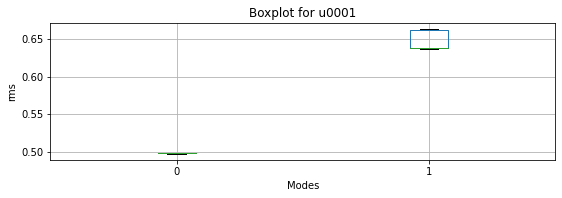

In [19]:
image_boxplot = plotting.modes_boxplot(df_u0001, "rms", SOURCE_IDS[0])

We create a list with all the sources dataframes for the "ModeId" feature and display the "RMS" boxplot across the different modes.

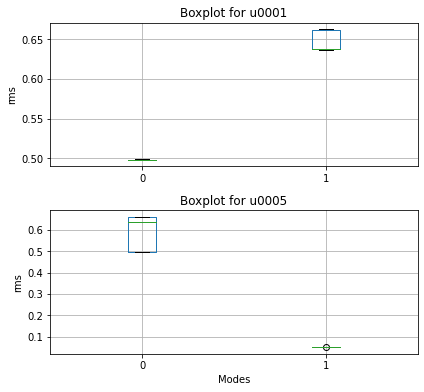

In [20]:
plotting.modes_group_boxplot([df_u0001, df_u0005], "rms", SOURCE_IDS)

We call the display over time of an individual source and identify all its operating modes.

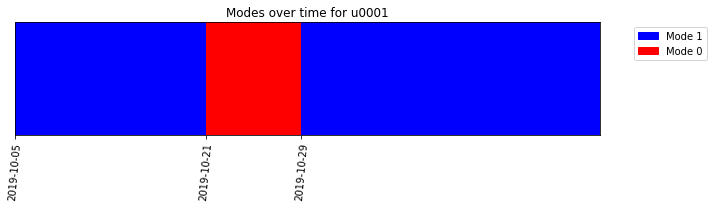

In [21]:
image_modes = plotting.modes_over_time(df_u0001, SOURCE_IDS[0])

We create a list with all the sources dataframes and display the modes over time for all.

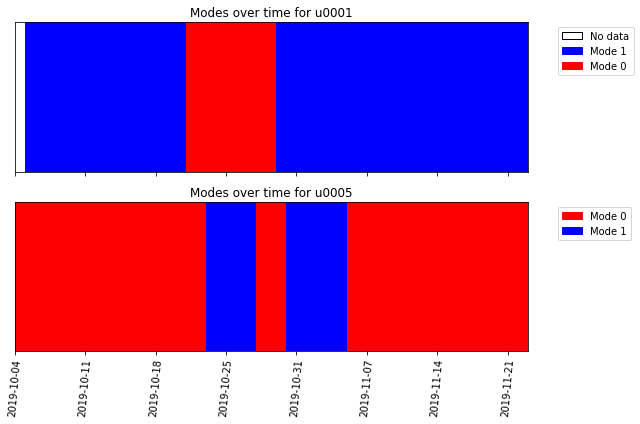

In [22]:
plotting.modes_over_time_group([df_u0001, df_u0005], SOURCE_IDS)